In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import pylab as pl

# Load the aggregated adjacency matrices

In [2]:
contact_adj_mat_files = ['output/temporally_aggregate_matrices/contact/agg_mat_InVS13.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_InVS15.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_LH10.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_LyonSchool.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_SFHH.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_Thiers13.npy']

copresence_adj_mat_files = ['output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS13.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS15.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LH10.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LyonSchool.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_SFHH.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_Thiers13.npy']

agg_mat_InVS13 = np.load(contact_adj_mat_files[0])
agg_mat_InVS15 = np.load(contact_adj_mat_files[1])
agg_mat_LH10 = np.load(contact_adj_mat_files[2])
agg_mat_LyonSchool = np.load(contact_adj_mat_files[3])
agg_mat_SFHH = np.load(contact_adj_mat_files[4])
agg_mat_Thiers13 = np.load(contact_adj_mat_files[5])

agg_mat_pres_InVS13 = np.load(copresence_adj_mat_files[0])
agg_mat_pres_InVS15 = np.load(copresence_adj_mat_files[1])
agg_mat_pres_LH10 = np.load(copresence_adj_mat_files[2])
agg_mat_pres_LyonSchool = np.load(copresence_adj_mat_files[3])
agg_mat_pres_SFHH = np.load(copresence_adj_mat_files[4])
agg_mat_pres_Thiers13 = np.load(copresence_adj_mat_files[5])

# Function definitions for global scale graph properties

In [8]:
def get_num_vertices(adj_mat):
    return adj_mat.shape[0]

def get_num_edges(adj_mat):
    n = get_num_vertices(adj_mat)
    upper_tri_idx = np.triu_indices(n, 1)
    return np.count_nonzero(adj_mat[upper_tri_idx])

def compute_graph_volume(adj_mat):
    return np.sum(adj_mat)

def compute_graph_density(adj_mat):
    n = get_num_vertices(adj_mat)
    m = get_num_edges(adj_mat)
    
    density = float(2 * m)/float(n * (n - 1))
    return density

In [9]:
get_num_vertices(agg_mat_InVS13)

100L

In [10]:
get_num_edges(agg_mat_InVS13)

755

In [11]:
compute_graph_volume(agg_mat_InVS13)

19654.0

In [12]:
compute_graph_density(agg_mat_InVS13)

0.15252525252525254

# Function definitions for local scale graph properties

In [189]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def compute_degree_distribution(adj_mat):
    # Assuming a simple, possibly weighted graph, degree of each vertex
    # will be the sum along one axis
    deg_arr = np.sum(adj_mat, axis=0)
    return deg_arr

def compute_average_degree(adj_mat):
    deg_arr = compute_degree_distribution(adj_mat)
    n = get_num_vertices(adj_mat)
    
    avg_deg = float(sum(deg_arr))/float(n)
    return avg_deg

def display_degree_distribution(adj_mat, dataset_name, override_min, num_bins_log_log=50):
    deg_arr = compute_degree_distribution(adj_mat)
    #deg_arr = reject_outliers(deg_arr)
    # Display histogram of degree distribution
    plt.subplot(2, 1, 1)
    plt.hist(deg_arr, bins='auto')
    plt.title('Deg Dist of {}'.format(dataset_name))
    
    # Display histogram of degree distribution with log-log plot
    plt.subplot(2, 1, 2)
    max_val = np.amax(adj_mat)
    min_val = np.amin(adj_mat[adj_mat > override_min])
    print min_val
    pow_ten_min = 10 ** (np.floor(np.log10(min_val+0.1)))
    pow_ten_max = 10 ** (np.ceil(np.log10(max_val)))
    plt.hist(deg_arr, bins=np.logspace(np.log10(pow_ten_min), np.log10(pow_ten_max), num_bins_log_log))
    plt.gca().set_xscale('log')
    plt.title('Log-Log Deg Dist of {}'.format(dataset_name))
    
    plt.show()
    
def get_neighborhood_set_of_node(adj_mat, node):
    nbrhd = []
    n = get_num_vertices(adj_mat)
    
    # Find all edges connecting node to other nodes
    for j in range(0, n):
        if adj_mat[node][j] != 0:
            nbrhd.append(j)
    return nbrhd
    
def compute_clustering_coefficient(adj_mat, node):
    # Get the degree of the node
    node_deg = compute_degree_distribution(adj_mat)[node]
    
    if node_deg <= 1:
        #print("Node {} has degree {}. CC is undefined".format(node, node_deg))
        return 0
    
    # Get the neighborhood set of the node
    nbrhd = get_neighborhood_set_of_node(adj_mat, node)
       
    # Get reduced neighborhood matrix of node
    nbrhd_matrix = adj_mat[:, nbrhd]
    nbrhd_matrix = nbrhd_matrix[nbrhd, :]
       
    # Count the number of triangles formed by the neighborhood set
    num_triangles = np.sum(nbrhd_matrix)

    # Compute the clustering coefficient and add it to the array
    clustering_coefficient = float(2 * num_triangles)/float(node_deg * (node_deg - 1))
    return clustering_coefficient
    
def compute_all_clustering_coefficients(adj_mat):
    # For each node in the graph, compute the clustering coefficient and store
    # it in an array
    n = get_num_vertices(adj_mat)
    cluster_coeff_arr = np.zeros((n, 1))
    
    for node in range(0, n):
        # Compute the clustering coefficient and add it to the array
        cluster_coeff_arr[node] = compute_clustering_coefficient(adj_mat, node)
        
    return cluster_coeff_arr    

def display_clustering_coefficient_dist(adj_mat, dataset_name, num_bins_log_log=50):
    cluster_coeff_arr = compute_all_clustering_coefficients(adj_mat)
    #cluster_coeff_arr = reject_outliers(cluster_coeff_arr)
    # Display histogram of clustering coefficients
    plt.subplot(2, 1, 1)
    plt.hist(cluster_coeff_arr, bins='auto')
    plt.title('CC Dist of {}'.format(dataset_name))
    
    # Display histogram of degree distribution with log-log plot
    plt.subplot(2, 1, 2)
    max_val = np.amax(cluster_coeff_arr)
    min_val = np.amin(cluster_coeff_arr)
    pow_ten_min = 10 ** (np.floor(np.log10(min_val+0.1)))
    pow_ten_max = 10 ** (np.ceil(np.log10(max_val)))
    plt.hist(deg_arr, bins=np.logspace(np.log10(pow_ten_min), np.log10(pow_ten_max), num_bins_log_log))
    plt.gca().set_xscale('log')
    plt.title('Log-Log CC Dist of {}'.format(dataset_name))
    
    plt.show()

def compute_average_clustering_coefficient(adj_mat):
    n = get_num_vertices(adj_mat)
    avg_cc = float(np.sum(compute_all_clustering_coefficients(adj_mat)))/float(n)
    return avg_cc
   

In [190]:
deg_arr = compute_degree_distribution(agg_mat_InVS13)
deg_arr

array([    0.,     0.,   173.,   104.,    70.,   137.,    48.,   230.,
          96.,   323.,   186.,   736.,    79.,   173.,   146.,    11.,
           0.,   496.,   373.,   143.,   220.,   253.,    93.,    37.,
         160.,   419.,   208.,   659.,     0.,   131.,   181.,   216.,
         446.,   994.,   185.,   103.,    86.,   287.,    75.,   403.,
          51.,   390.,    98.,   177.,    64.,     8.,   101.,    36.,
         294.,   312.,    82.,    16.,   414.,   122.,     0.,   314.,
         299.,   269.,  1091.,     5.,   285.,    90.,   124.,   628.,
          95.,     0.,     0.,   123.,    86.,   422.,   328.,   233.,
         241.,    75.,   112.,    50.,   358.,   289.,    33.,   171.,
         268.,   171.,   404.,   119.,   187.,    87.,   372.,    63.,
           0.,    54.,   105.,    17.,   427.,   155.,   207.,    74.,
         236.,    21.,    96.,    25.])

In [191]:
compute_average_degree(agg_mat_InVS13)

196.54

11.0


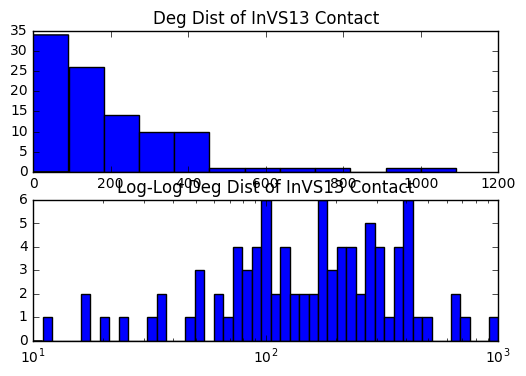

In [192]:
display_degree_distribution(agg_mat_InVS13, 'InVS13 Contact', 10)

In [68]:
test_neighbors = get_neighborhood_set_of_node(agg_mat_InVS13, 22)
test_nbrhd_matrix = agg_mat_InVS13[:, test_neighbors]
test_nbrhd_matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   0.,  80., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   4., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.]])

In [69]:
compute_clustering_coefficient(agg_mat_InVS13, 22)

0.6563814866760168

In [71]:
compute_all_clustering_coefficients(agg_mat_InVS13)

Node 0 has degree 0.0. CC is undefined
Node 1 has degree 0.0. CC is undefined
Node 16 has degree 0.0. CC is undefined
Node 28 has degree 0.0. CC is undefined
Node 54 has degree 0.0. CC is undefined
Node 65 has degree 0.0. CC is undefined
Node 66 has degree 0.0. CC is undefined
Node 88 has degree 0.0. CC is undefined


array([[  0.00000000e+00],
       [  0.00000000e+00],
       [  8.26724022e-02],
       [  2.99477222e-01],
       [  4.20703934e-01],
       [  3.54873336e-01],
       [  1.22340426e+00],
       [  1.29105753e-01],
       [  1.79824561e-01],
       [  3.01521066e-02],
       [  8.03254868e-02],
       [  1.67997634e-02],
       [  8.76338851e-02],
       [  1.54052964e-01],
       [  2.32782239e-01],
       [  3.63636364e-02],
       [  0.00000000e+00],
       [  3.92798957e-02],
       [  6.97627490e-03],
       [  1.51482320e-01],
       [  8.05313408e-03],
       [  3.75807767e-02],
       [  6.56381487e-01],
       [  6.96696697e-01],
       [  1.19968553e-01],
       [  2.53051809e-02],
       [  9.87551096e-02],
       [  1.99344129e-02],
       [  0.00000000e+00],
       [  2.43570170e-01],
       [  1.48557397e-02],
       [  1.42721792e-01],
       [  4.10742178e-02],
       [  6.58938525e-03],
       [  2.60869565e-01],
       [  1.77041690e-01],
       [  3.22298222e-01],
 

In [72]:
compute_average_clustering_coefficient(agg_mat_InVS13)

Node 0 has degree 0.0. CC is undefined
Node 1 has degree 0.0. CC is undefined
Node 16 has degree 0.0. CC is undefined
Node 28 has degree 0.0. CC is undefined
Node 54 has degree 0.0. CC is undefined
Node 65 has degree 0.0. CC is undefined
Node 66 has degree 0.0. CC is undefined
Node 88 has degree 0.0. CC is undefined


0.30560914630609887

In [73]:
compute_average_clustering_coefficient(agg_mat_pres_LyonSchool)

0.014348216510121246

# Graph Comparison

-Compare contact and co-presence graphs using statistics

-Stats to compare: number of vertices, number of edges, volume, density, 
 degree distribution, average degree, clustering coefficient, avg CC

### Table of Statistics

In [98]:
single_stats = []

data = ['InVS13_contact']
A = agg_mat_InVS13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['InVS13_copresence']
A = agg_mat_pres_InVS13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['InVS15_contact']
A = agg_mat_InVS15
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['InVS15_copresence']
A = agg_mat_pres_InVS15
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LH10_contact']
A = agg_mat_LH10
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LH10_copresence']
A = agg_mat_pres_LH10
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LyonSchool_contact']
A = agg_mat_LyonSchool
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LyonSchool_copresence']
A = agg_mat_pres_LyonSchool
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['SFHH_contact']
A = agg_mat_SFHH
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['SFHH_copresence']
A = agg_mat_pres_SFHH
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['Thiers13_contact']
A = agg_mat_Thiers13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['Thiers13_copresence']
A = agg_mat_pres_Thiers13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

column_names = ['Dataset', 'Num Vertices', 'Num Edges', 'Volume',
                'Density', 'Avg Degree', 'Avg Clustering Coeff']
df = pd.DataFrame(single_stats, columns = column_names)

df


,Dataset,Num Vertices,Num Edges,Volume,Density,Avg Degree,Avg Clustering Coeff
0,InVS13_contact,100,755,19654.0,0.152525,196.540000,0.305609
1,InVS13_copresence,100,3915,788494.0,0.790909,7884.940000,0.107295
2,InVS15_contact,232,4274,156498.0,0.159501,674.560345,0.235446
3,InVS15_copresence,232,16725,2566388.0,0.624160,11062.017241,0.071918
4,LH10_contact,81,1156,66140.0,0.356790,816.543210,3.144838
5,LH10_copresence,81,1381,300252.0,0.426235,3706.814815,10.469907
6,LyonSchool_contact,242,8317,251546.0,0.285210,1039.446281,0.144241
7,LyonSchool_copresence,242,26594,13188984.0,0.911971,54499.933884,0.014348
8,SFHH_contact,403,9565,140522.0,0.118082,348.689826,0.513001
9,SFHH_copresence,403,73557,2834970.0,0.908077,7034.665012,0.562975


### Degree Distributions and Clustering Coefficients

11.0


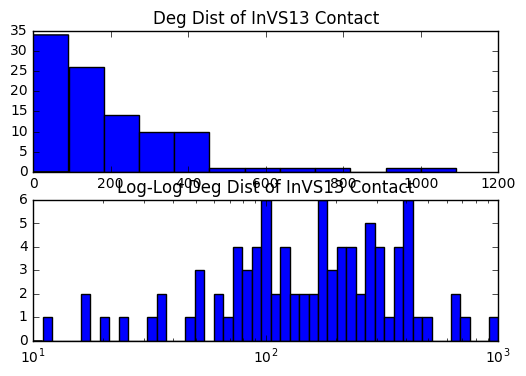

11.0


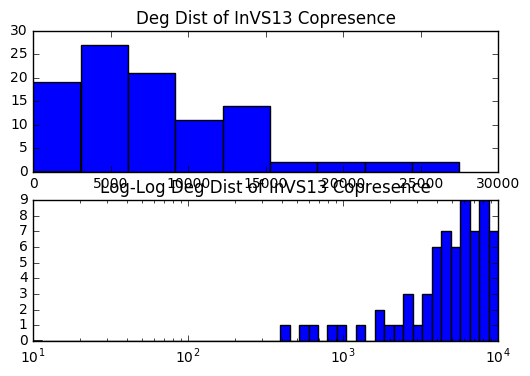

11.0


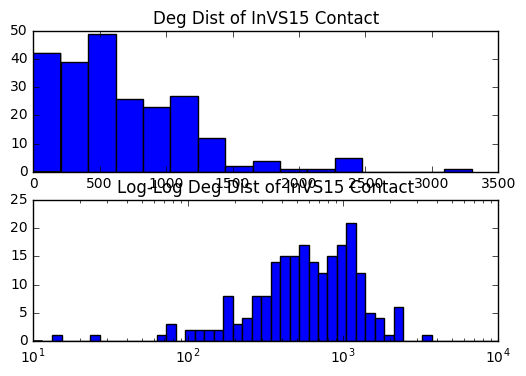

11.0


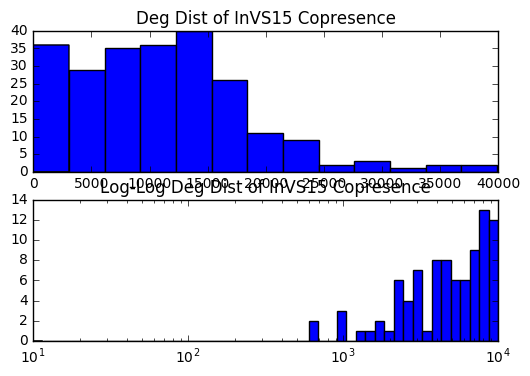

11.0


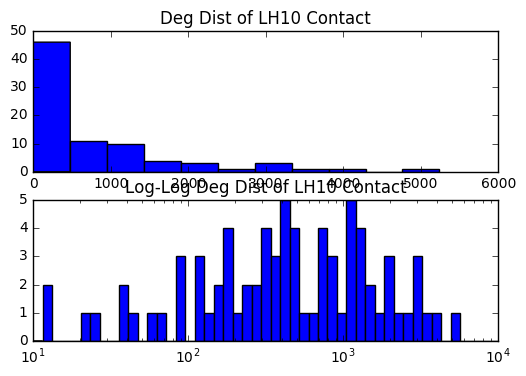

11.0


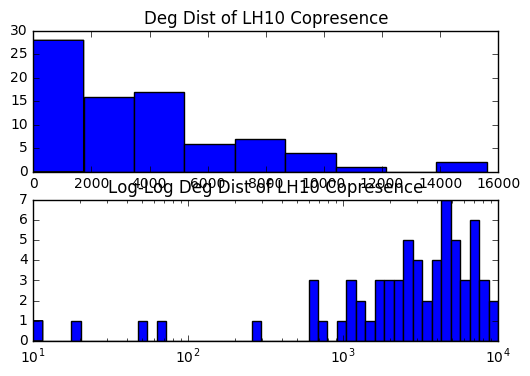

11.0


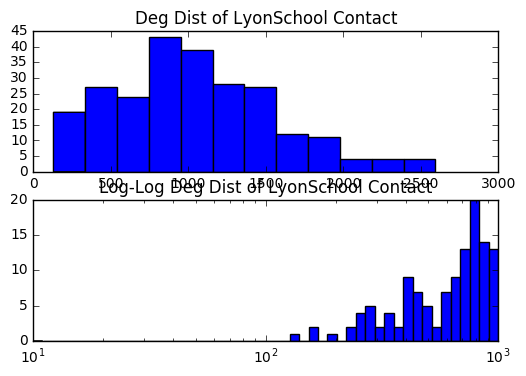

1002.0


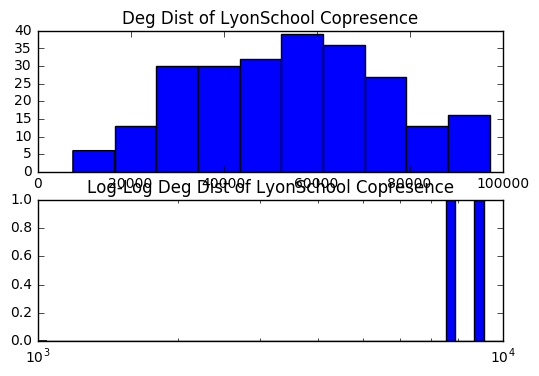

11.0


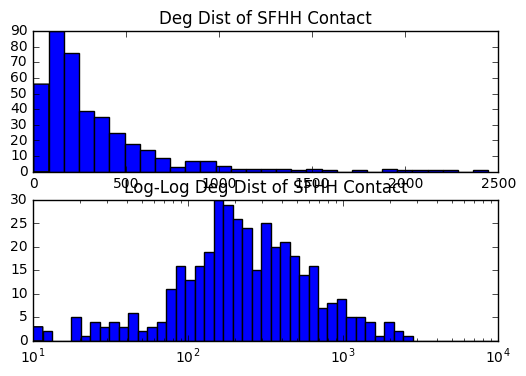

11.0


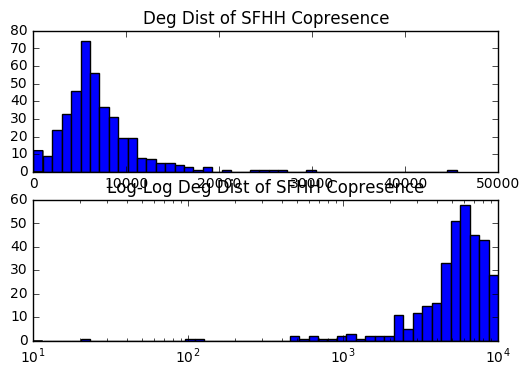

11.0


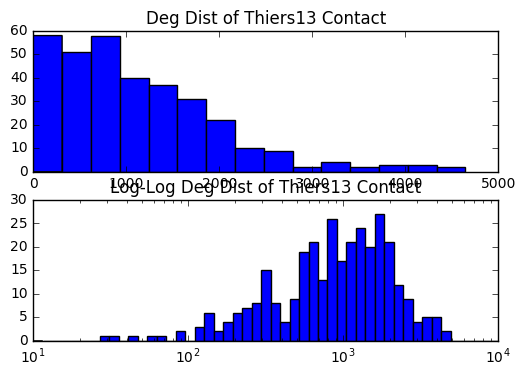

101.0


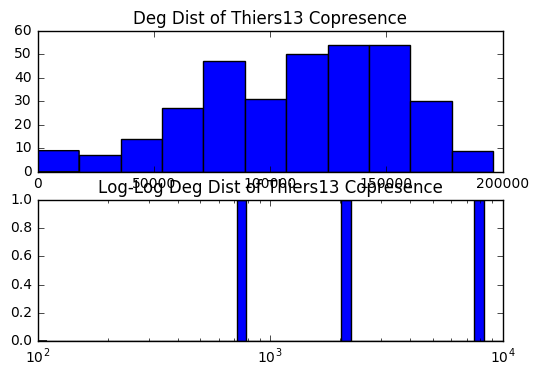

In [ ]:
display_degree_distribution(agg_mat_InVS13, 'InVS13 Contact', 10)
display_degree_distribution(agg_mat_pres_InVS13, 'InVS13 Copresence', 10)
display_degree_distribution(agg_mat_InVS15, 'InVS15 Contact', 10)
display_degree_distribution(agg_mat_pres_InVS15, 'InVS15 Copresence', 10)
display_degree_distribution(agg_mat_LH10, 'LH10 Contact', 10)
display_degree_distribution(agg_mat_pres_LH10, 'LH10 Copresence', 10)
display_degree_distribution(agg_mat_LyonSchool, 'LyonSchool Contact', 10)
display_degree_distribution(agg_mat_pres_LyonSchool, 'LyonSchool Copresence', 1000)
display_degree_distribution(agg_mat_SFHH, 'SFHH Contact', 10)
display_degree_distribution(agg_mat_pres_SFHH, 'SFHH Copresence', 10)
display_degree_distribution(agg_mat_Thiers13, 'Thiers13 Contact', 10)
display_degree_distribution(agg_mat_pres_Thiers13, 'Thiers13 Copresence', 100)

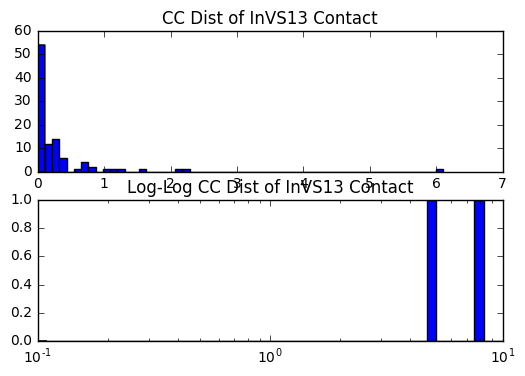

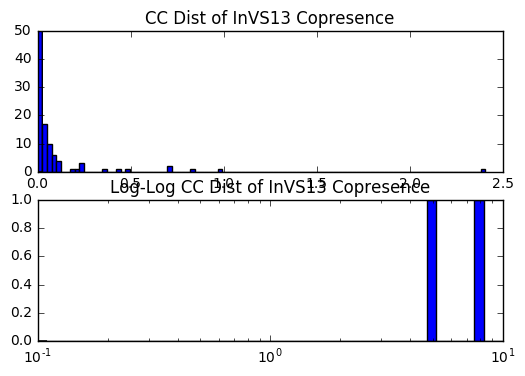

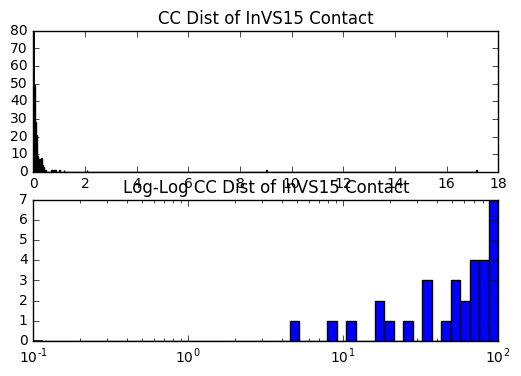

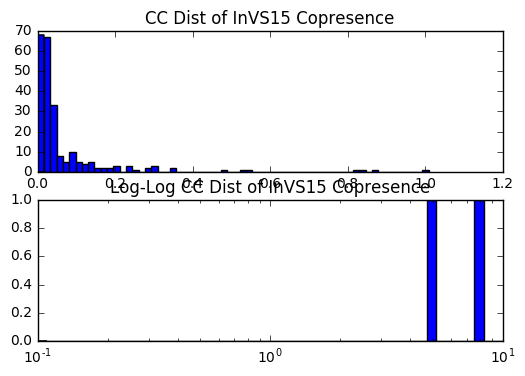

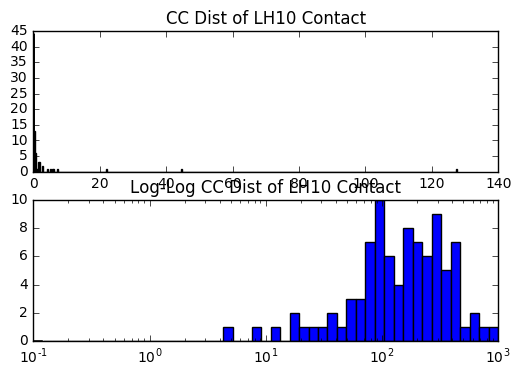

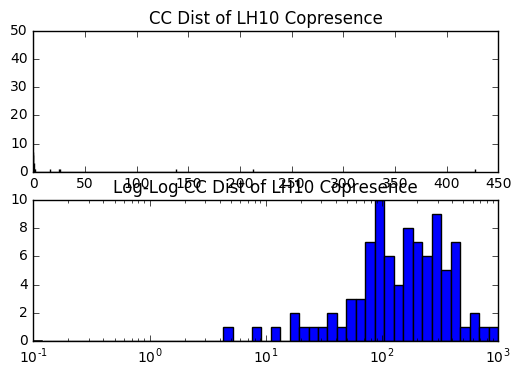

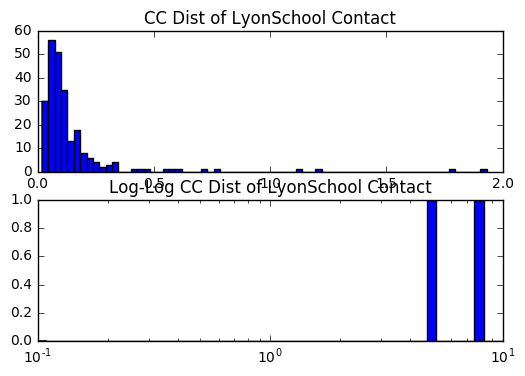

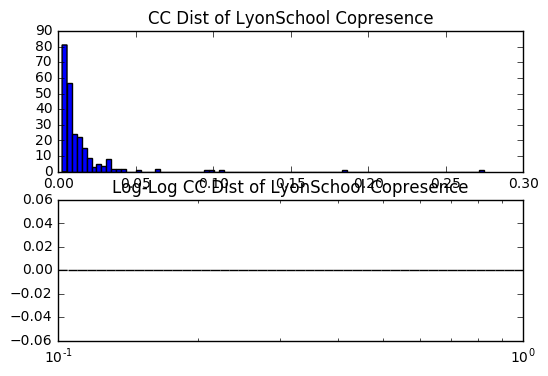

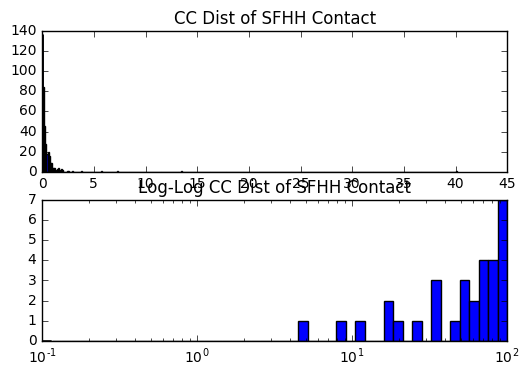

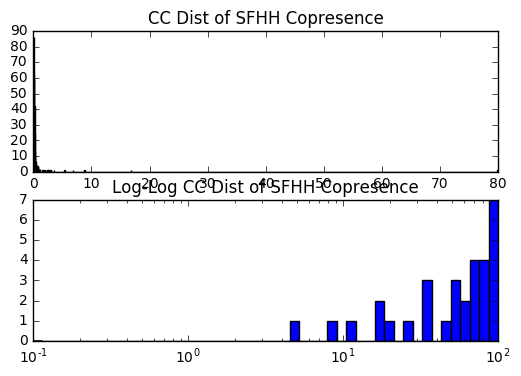

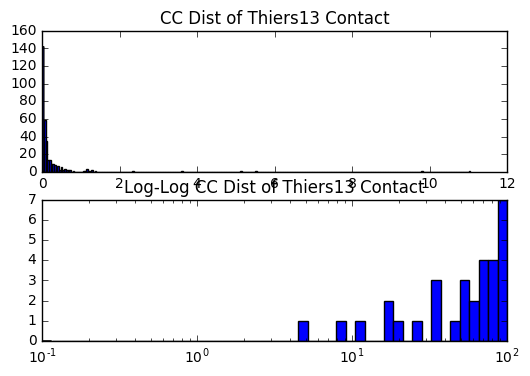

In [ ]:
display_clustering_coefficient_dist(agg_mat_InVS13, 'InVS13 Contact')
display_clustering_coefficient_dist(agg_mat_pres_InVS13, 'InVS13 Copresence')
display_clustering_coefficient_dist(agg_mat_InVS15, 'InVS15 Contact')
display_clustering_coefficient_dist(agg_mat_pres_InVS15, 'InVS15 Copresence')
display_clustering_coefficient_dist(agg_mat_LH10, 'LH10 Contact')
display_clustering_coefficient_dist(agg_mat_pres_LH10, 'LH10 Copresence')
display_clustering_coefficient_dist(agg_mat_LyonSchool, 'LyonSchool Contact')
display_clustering_coefficient_dist(agg_mat_pres_LyonSchool, 'LyonSchool Copresence')
display_clustering_coefficient_dist(agg_mat_SFHH, 'SFHH Contact')
display_clustering_coefficient_dist(agg_mat_pres_SFHH, 'SFHH Copresence')
display_clustering_coefficient_dist(agg_mat_Thiers13, 'Thiers13 Contact')
display_clustering_coefficient_dist(agg_mat_pres_Thiers13, 'Thiers13 Copresence')

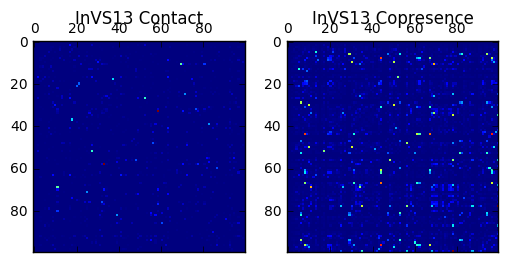

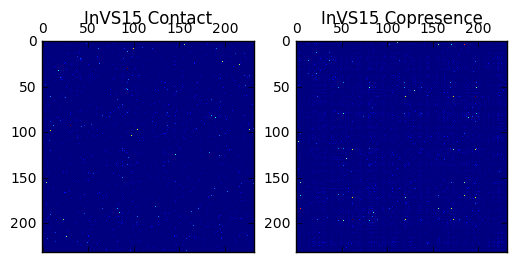

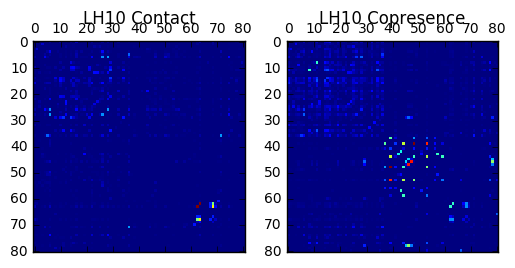

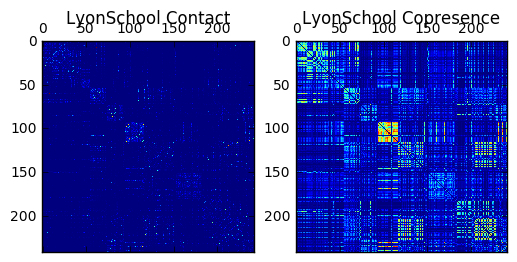

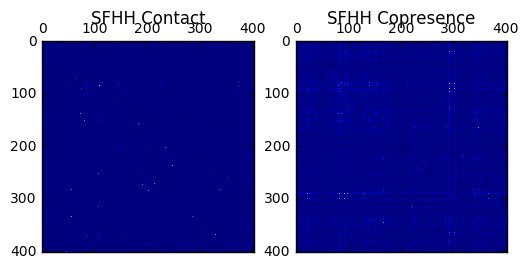

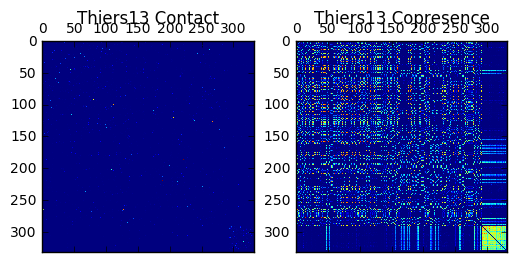

In [184]:
plt.subplot(1, 2, 1)
plt.matshow(agg_mat_InVS13, fignum=False)
plt.title('InVS13 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_InVS13, fignum=False)
plt.title('InVS13 Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_InVS15, fignum=False)
plt.title('InVS15 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_InVS15, fignum=False)
plt.title('InVS15 Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_LH10, fignum=False)
plt.title('LH10 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_LH10, fignum=False)
plt.title('LH10 Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_LyonSchool, fignum=False)
plt.title('LyonSchool Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_LyonSchool, fignum=False)
plt.title('LyonSchool Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_SFHH, fignum=False)
plt.title('SFHH Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_SFHH, fignum=False)
plt.title('SFHH Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_Thiers13, fignum=False)
plt.title('Thiers13 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_Thiers13, fignum=False)
plt.title('Thiers13 Copresence')
plt.show()